In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import MNIST
from scipy.spatial.distance import cdist
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from PIL import Image
from matplotlib.patches import Ellipse
from scipy.spatial import distance
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import torch
import torch.nn.functional as F
from torch.optim import Adam
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import numpy as np
import networkx as nx



In [ ]:
taxa = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/data/Bio_data/final_taxa.csv")
meta = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/data/Bio_data/final_clean_meta.csv")

In [ ]:
taxa_data = taxa.drop(columns=taxa.columns[0])
taxa_data = taxa_data.fillna(taxa_data.mean())
taxa_index = taxa.iloc[:, 0]



In [ ]:

# Check if values in 'taxa_index' are present in the '#Sample_Id' column
matching_samples = set(taxa_index) & set(meta['#SampleID'])

# Count the number of matching samples
num_matching_samples = len(matching_samples)

# Display the count
print("Number of matching samples:", num_matching_samples)


Number of matching samples: 1358


In [ ]:
matching_samples

{'SKBTI.1334.1247137',
 '122058.1246184',
 'SKBTI.0198.1246368',
 'SKBTI.0674.1246315',
 'SKBTI.0230.1247214',
 'SKBTI.0878.1246465',
 'SKBTI.0115.1247421',
 'SKBTI.0762.1247378',
 'SKBTI.1065.1246587',
 'SKBTI.0555.1246287',
 'SKBTI.0218.1246657',
 'SKBTI.0761.1246264',
 'MGH100695.1247456',
 'SKBTI.1327.1246128',
 '121217.1246974',
 'SKBTI.0689.1246344',
 '121959.1247341',
 'SKBTI.0246.1247381',
 'SKBTI.0150.1246545',
 'SKBTI.0541.1246998',
 'SKBTI.0271.1246360',
 'SKBTI.0163.1247195',
 'SKBTI.1299.1247431',
 'SKBTI.0523.1246271',
 'SKBTI.0615.1246962',
 'SKBTI.0599.1246538',
 'SKBTI.0100.1246820',
 'SKBTI.0613.1246236',
 'SKBTI.1259.1247265',
 'MGH103029.1246825',
 'MGH104119.1246223',
 'SKBTI.0581.1247204',
 'SKBTI.1255.1246440',
 'SKBTI.0912.1247348',
 'SKBTI.0520.1246392',
 'MGH113527.1246397',
 'SKBTI006.1247355',
 '121314.1247259',
 'SKBTI.1097.1246573',
 'SKBTI.0516.1247182',
 'SKBTI.1252.1247124',
 'SKBTI.0994.1246822',
 'SKBTI.1144.1246149',
 '121307.1246550',
 'SKBTI.1136.1

In [ ]:
meta['GASTROINTEST_DISORD']

0       IC
1       CD
2       CD
3       no
4       CD
        ..
1353    CD
1354    CD
1355    CD
1356    CD
1357    no
Name: GASTROINTEST_DISORD, Length: 1358, dtype: object

In [ ]:
gastro_column = meta['GASTROINTEST_DISORD']

# Create a new column with 1 where 'no' and 0 otherwise
#meta['GASTROINTEST_DISORD_binary'] = gastro_column.apply(lambda x: 1 if x == 'no' else 0)
meta['GASTROINTEST_DISORD_binary'] = gastro_column.apply(lambda x: 1 if x == 'no' or x == 'CD' else (2 if x == 'IC' else 0))
label = meta['GASTROINTEST_DISORD_binary'].values
# Display the updated DataFrame
print(meta)

               #SampleID BarcodeSequence LinkerPrimerSequence  \
0     SKBTI.1325.1246591            None  GTGCCAGCMGCCGCGGTAA   
1         121283.1246600            None  GTGCCAGCMGCCGCGGTAA   
2     SKBTI.0870.1246169            None  GTGCCAGCMGCCGCGGTAA   
3     SKBTI.1178.1246304            None  GTGCCAGCMGCCGCGGTAA   
4      MGH101468.1246593            None  GTGCCAGCMGCCGCGGTAA   
...                  ...             ...                  ...   
1353  SKBTI.0518.1246864            None  GTGCCAGCMGCCGCGGTAA   
1354  SKBTI.1317.1247132            None  GTGCCAGCMGCCGCGGTAA   
1355    SKBTI024.1246988            None  GTGCCAGCMGCCGCGGTAA   
1356  SKBTI.1035.1246669            None  GTGCCAGCMGCCGCGGTAA   
1357    SKBTI089.1247376            None  GTGCCAGCMGCCGCGGTAA   

     TARGET_SUBFRAGMENT ASSIGNED_FROM_GEO EXPERIMENT_CENTER      TITLE  \
0                    V4                 n                BI  CCFA_RISK   
1                    V4                 n                BI  CCFA_RISK 

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=6):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h[:, :self.latent_dim], h[:, self.latent_dim:]
        return mu, logvar

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, beta=0.02):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)

        # Calculate the reconstruction loss (MSE)
        reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')

        # Calculate the KL divergence
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Combine the reconstruction loss and KL divergence
        total_loss = reconstruction_loss + beta * kl_divergence

        return x_hat, mu, logvar, total_loss

In [ ]:
def train(model, train_loader, learning_rate, num_epochs, device, beta_initial, beta_step):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    def loss_function(x_hat, x, z_mean, z_logvar, beta):
        bce_loss = F.mse_loss(x_hat, x, reduction='mean')
        kld_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
        return bce_loss + (beta * kld_loss)

    model.train()
    beta = beta_initial  # Initialize 'beta' with a small value

    # Define a learning rate scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

    reconstruction_losses = []
    kl_divergences = []
    total_losses = []  # Store total loss at each iteration
    for epoch in range(num_epochs):

        total_loss = 0.0
        total_reconstruction_loss = 0.0
        total_kl_divergence = 0.0

        for batch_idx, x in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, mu, logvar, _ = model(x, beta)  # Use "_" to ignore the returned total loss

            reconstruction_loss = F.mse_loss(x_hat, x, reduction='mean') * x.numel()  # Adjustment for mean reduction
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            loss = loss_function(x_hat, x, mu, logvar, beta)

            reconstruction_losses.append(reconstruction_loss.item())
            kl_divergences.append(kl_divergence.item())
            total_losses.append(loss.item())

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_reconstruction_loss += reconstruction_loss.item()
            total_kl_divergence += kl_divergence.item()

        avg_loss = total_loss / (batch_idx + 1)  # Divide by the number of batches
        avg_reconstruction_loss = total_reconstruction_loss / (batch_idx + 1)  # Divide by the number of batches
        avg_kl_divergence = total_kl_divergence / (batch_idx + 1)  # Divide by the number of batches
        print('Epoch [{}/{}], Average Loss: {:.4f}, Beta: {:.4f}'.format(epoch+1, num_epochs, avg_loss, beta))
        print('Reconstruction Loss: {:.4f}, KL Divergence: {:.4f}'.format(avg_reconstruction_loss, avg_kl_divergence))

        # Increase 'beta' for the next epoch
        beta += beta_step  # Adjust 'beta' as needed

        # Step the learning rate scheduler
        scheduler.step()

    # Plot the KL divergence and reconstruction loss + loss
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.plot(range(len(kl_divergences)), kl_divergences, label='KL Divergence')
    plt.xlabel('Batch Index')
    plt.ylabel('KL Divergence')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(range(len(reconstruction_losses)), reconstruction_losses, label='Reconstruction Loss')
    plt.xlabel('Batch Index')
    plt.ylabel('Reconstruction Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(range(len(total_losses)), total_losses, label='Total Loss')
    plt.xlabel('Batch Index')
    plt.ylabel('Total Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


## **Standardize numeric data**

In [ ]:
class TabularDataset(Dataset):
    def __init__(self, dataframe):
        # Identify numeric columns
        numeric_columns = dataframe.select_dtypes(include=['number']).columns

        # Standardize numeric data (mean=0, std=1)
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(dataframe[numeric_columns].values)

        self.data = torch.tensor(scaled_data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Usage
dataset = TabularDataset(dataframe=taxa_data)
batch_size =  16
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# **MinMax Scaling**


>  MinMax scaling to scale your features to a specific range, preserving the relative proportions of values.



In [ ]:
from sklearn.preprocessing import MinMaxScaler

class TabularDataset(Dataset):
    def __init__(self, dataframe):
        # Identify numeric columns
        numeric_columns = dataframe.select_dtypes(include=['number']).columns

        # Standardize numeric data (mean=0, std=1)
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(dataframe[numeric_columns].values)

        self.data = torch.tensor(scaled_data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Usage
dataset = TabularDataset(dataframe=taxa_data)
batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# **Robust Scaling**


> Robust scaling is another option that is less sensitive to outliers. It scales features based on percentiles, making it suitable for data with extreme values



In [ ]:
from sklearn.preprocessing import RobustScaler

class TabularDataset(Dataset):
    def __init__(self, dataframe):
        # Identify numeric columns
        numeric_columns = dataframe.select_dtypes(include=['number']).columns

        # Standardize numeric data (mean=0, std=1)
        scaler = RobustScaler()
        scaled_data = scaler.fit_transform(dataframe[numeric_columns].values)

        self.data = torch.tensor(scaled_data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Usage
dataset = TabularDataset(dataframe=taxa_data )
batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# **NO-Normalazation**

In [ ]:
class TabularDataset(Dataset):
    def __init__(self, dataframe):
        self.data = torch.tensor(dataframe.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Usage
dataset = TabularDataset(dataframe=taxa_data)
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# **Log Transformation**



> can be beneficial for data with a wide range of values.



In [ ]:

class TabularDataset(Dataset):
    def __init__(self, dataframe):
        # Identify numeric columns
        numeric_columns = dataframe.select_dtypes(include=['number']).columns

        # Standardize numeric data (mean=0, std=1)
        log_transformed_data = np.log1p(dataframe[numeric_columns].values)

        self.data = torch.tensor(log_transformed_data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Usage
dataset = TabularDataset(dataframe=taxa_data)
batch_size =  32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

[κείμενο συνδέσμου](https://) **Zero-Inflated Transformation**

 dataset contains many zeros, consider using a zero-inflated transformation. This approach separately models the zeros and the non-zero values. For instance, you could use a zero-inflated log transformation, which applies a log transformation to non-zero values while maintaining zeros.


In [ ]:
class TabularDataset(Dataset):
    def __init__(self, dataframe):
        # Identify numeric columns
        numeric_columns = dataframe.select_dtypes(include=['number']).columns
        data = dataframe[numeric_columns]

        # Apply zero-inflated log transformation
        data_transformed = data.applymap(lambda x: np.log1p(x) if x > 0 else x)

        self.data = torch.tensor(data_transformed.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Usage
dataset = TabularDataset(dataframe=taxa_data)
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Check the data have the normalization as you wanted


In [ ]:
data_tensor = dataset.data

# Convert the tensor to a numpy array
data_numpy = data_tensor.numpy()

# Convert the numpy array to a DataFrame for easier viewing
data_df = pd.DataFrame(data_numpy)

# Display the first few rows of the DataFrame
print(data_df.head())

        0         1         2    3         4         5         6         7    \
0  6.717805  2.995732  0.000000  0.0  0.000000  0.000000  0.000000  0.000000   
1  6.842683  4.605170  1.791759  0.0  0.000000  0.000000  0.000000  0.000000   
2  3.688879  2.995732  0.000000  0.0  0.000000  0.000000  0.000000  0.000000   
3  5.389072  6.525030  0.000000  0.0  1.098612  4.976734  0.693147  0.693147   
4  5.966147  5.147494  0.000000  0.0  0.000000  0.000000  0.000000  1.098612   

   8    9    ...  654       655  656       657  658  659       660  661  662  \
0  0.0  0.0  ...  0.0  3.332205  0.0  3.401197  0.0  0.0  0.000000  0.0  0.0   
1  0.0  0.0  ...  0.0  0.000000  0.0  2.197225  0.0  0.0  0.000000  0.0  0.0   
2  0.0  0.0  ...  0.0  0.000000  0.0  0.000000  0.0  0.0  1.098612  0.0  0.0   
3  0.0  0.0  ...  0.0  4.890349  0.0  1.791759  0.0  0.0  0.000000  0.0  0.0   
4  0.0  0.0  ...  0.0  0.000000  0.0  0.000000  0.0  0.0  0.693147  0.0  0.0   

        663  
0  0.000000  
1  0.00000

In [ ]:
input_dim = 664   # Adjust this to the actual number of features in your dataset
model = VAE(input_dim=input_dim)

# Define the training parameters
learning_rate = 1e-4
num_epochs = 100
batch_size = 32
beta_initial = 0.01  # Start with a small 'beta'
beta_step = 0.01  # Adjust the step size as neededt the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=664, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=664, bias=True)
    (7): Sigmoid()
  )
)

Epoch [1/100], Average Loss: 2755.9897, Beta: 0.0100
Reconstruction Loss: 56967118.0465, KL Divergence: 1611.7137
Epoch [2/100], Average Loss: 2720.8901, Beta: 0.0200
Reconstruction Loss: 56931680.3256, KL Divergence: 78.0333
Epoch [3/100], Average Loss: 2689.6131, Beta: 0.0300
Reconstruction Loss: 56872297.8023, KL Divergence: 46.9258
Epoch [4/100], Average Loss: 2694.6863, Beta: 0.0400
Reconstruction Loss: 56856212.3721, KL Divergence: 28.6437
Epoch [5/100], Average Loss: 2688.7122, Beta: 0.0500
Reconstruction Loss: 56853514.3256, KL Divergence: 18.2985
Epoch [6/100], Average Loss: 2716.5493, Beta: 0.0600
Reconstruction Loss: 56852898.5116, KL Divergence: 12.8301
Epoch [7/100], Average Loss: 2756.8423, Beta: 0.0700
Reconstruction Loss: 56852418.6047, KL Divergence: 12.6238
Epoch [8/100], Average Loss: 2696.3654, Beta: 0.0800
Reconstruction Loss: 56852239.1860, KL Divergence: 14.9190
Epoch [9/100], Average Loss: 2688.0108, Beta: 0.0900
Reconstruction Loss: 56852162.3372, KL Divergence

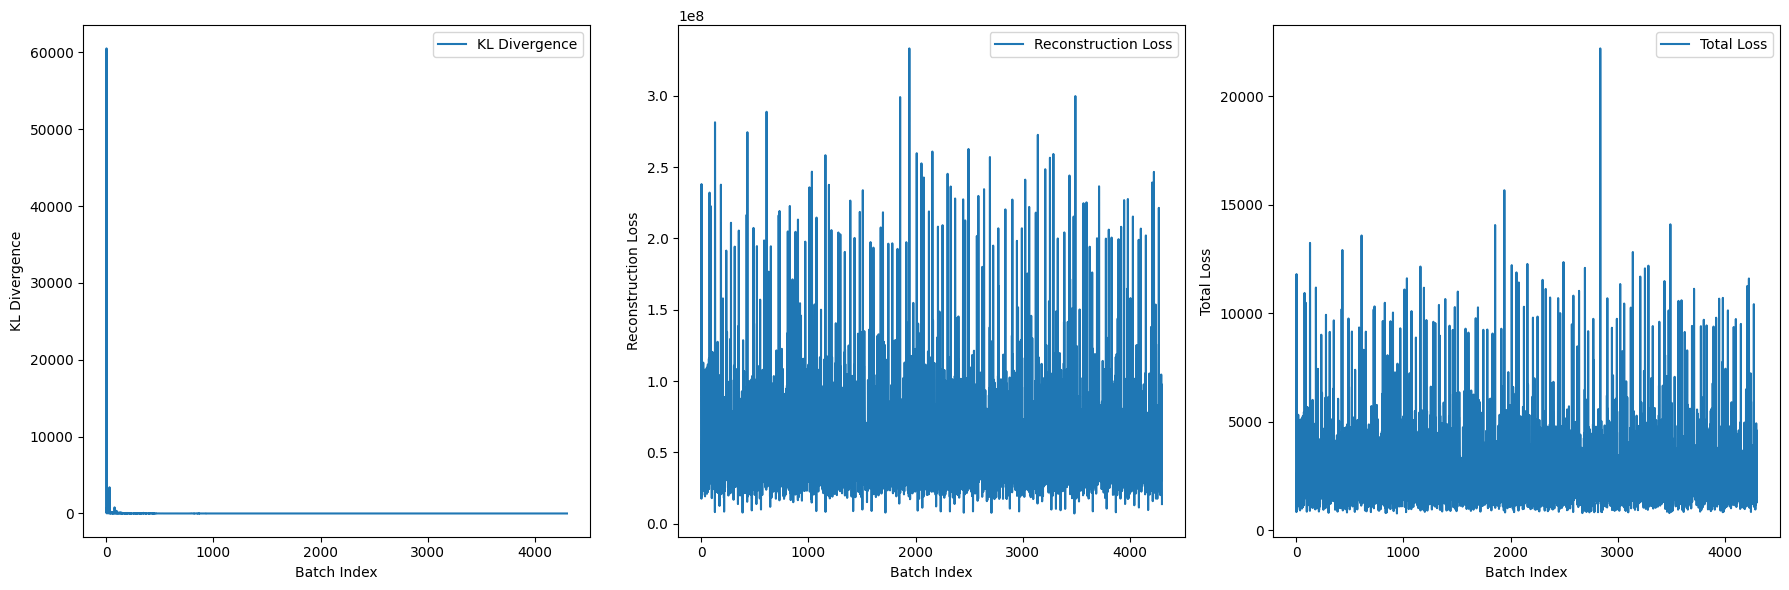

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=664, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=664, bias=True)
    (7): Sigmoid()
  )
)

In [ ]:
train(model, train_loader, learning_rate, 100, device, beta_initial, beta_step)


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Thesis/vae_model_no.pth')

In [ ]:
if next(model.parameters()).is_cuda:
    print("Model is running on CUDA (GPU)")
else:
    print("Model is running on CPU")

Model is running on CUDA (GPU)


In [ ]:
label.shape

(1358,)

<ipython-input-40-53b93235e817>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', num_unique_labels)


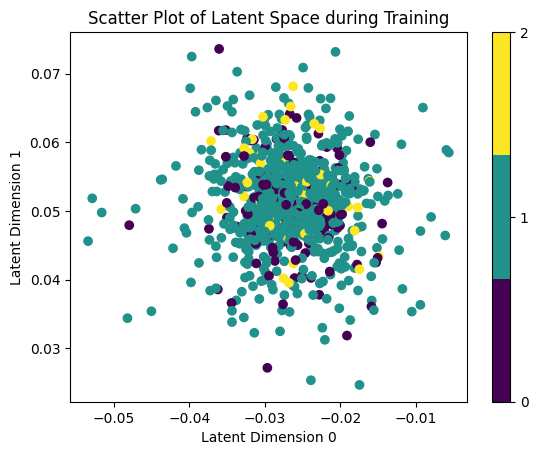

In [ ]:
vae_model = VAE(input_dim=input_dim, latent_dim=6)  # Make sure to provide the correct input and latent dimensions
vae_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Thesis/vae_model_no.pth'))
vae_model.eval()  # Set the model in evaluation mode

vae_model.to(device)

encoded_data = []
with torch.no_grad():
    for x in train_loader:
        x = x.to(device)  # Move data to the same device as the model
        _, mu, _, _ = vae_model(x)
        encoded_data.append(mu.cpu().numpy())

unique_labels = np.unique(label)  # Assuming 'label' contains your data labels
num_unique_labels = len(unique_labels)
color_map = plt.cm.get_cmap('viridis', num_unique_labels)

# Create scatter plot
plt.scatter(all_latents[:, 1], all_latents[:, 0], c=label, cmap=color_map)

# Customize color bar
cbar = plt.colorbar(ticks=range(num_unique_labels))
cbar.ax.set_yticklabels(unique_labels)  # Set the color bar labels to your unique labels

# Set plot title and labels
plt.title('Scatter Plot of Latent Space during Training')
plt.xlabel(f'Latent Dimension {latent_dim1}')
plt.ylabel(f'Latent Dimension {latent_dim2}')

plt.show()

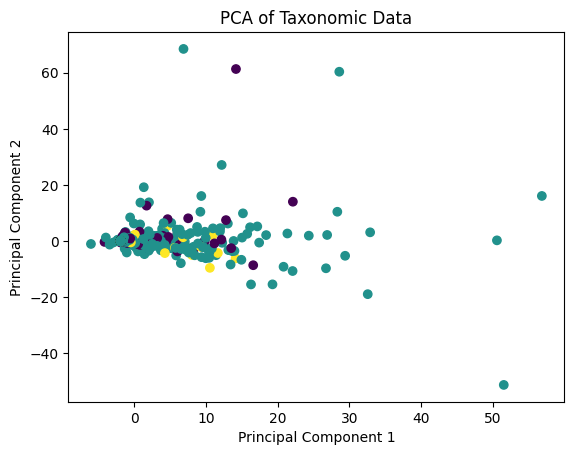

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming taxa_data is a 2D array or matrix where rows are samples and columns are features
# labels is a 1D array or list containing corresponding labels

# Step 1: Standardize the data
mean_vals = np.mean(taxa_data, axis=0)
std_devs = np.std(taxa_data, axis=0)
standardized_data = (taxa_data - mean_vals) / std_devs

# Step 2: Perform PCA
pca = PCA()
pca_result = pca.fit_transform(standardized_data)

# Step 3: Visualize the results (optional)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=label, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Taxonomic Data')
plt.show()


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming taxa_data is a 2D array or matrix where rows are samples and columns are features
# labels is a 1D array or list containing corresponding labels

# Step 1: Standardize the data
mean_vals = np.mean(taxa_data, axis=0)
std_devs = np.std(taxa_data, axis=0)
standardized_data = (taxa_data - mean_vals) / std_devs

# Step 2: Perform PCA
pca = PCA()
pca_result = pca.fit_transform(standardized_data)

# Step 3: Plot Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance of Principal Components')
plt.show()


Perfomring VAE with the top 200 data from the dataset. Keeping the weights for recostruction.


In [ ]:
import joblib  # For saving the model

pca = PCA(n_components=200)
pca.fit(taxa_data)

# Step 2: Transform the Data
taxa_data_transformed = pca.transform(taxa_data)

# The transformed data is now in a 200-dimensional space

# Saving the PCA model for later reconstruction
joblib.dump(pca, 'pca_model.pkl')

# When you need to reconstruct the original data
# Load the model and use the inverse transform
pca = joblib.load('/content/drive/MyDrive/Colab Notebooks/Thesis/pca_model.pkl')
taxa_data_reconstructed = pca.inverse_transform(taxa_data_transformed)

Use Pca - > 200dimns and then train VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=200, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim * 2)  # Output is 2*latent_dim for mean and log variance
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h[:, :self.latent_dim], h[:, self.latent_dim:]
        return mu, logvar

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, beta=0.02):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)

        # Calculate the reconstruction loss (MSE)
        reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')

        # Calculate the KL divergence
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Combine the reconstruction loss and KL divergence
        total_loss = reconstruction_loss + beta * kl_divergence

        return x_hat, mu, logvar, total_loss


In [ ]:

train_loader = DataLoader(taxa_data_transformed, batch_size=batch_size, shuffle=True)

In [ ]:
input_dim = 200   # Adjust this to the actual number of features in your dataset
model = VAE(input_dim=input_dim)

# Define the training parameters
learning_rate = 1e-4
num_epochs = 100
batch_size = 32
beta_initial = 0.01  # Start with a small 'beta'
beta_step = 0.01  # Adjust the step size as neededt the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.float()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=200, bias=True)
    (7): Sigmoid()
  )
)

In [ ]:
def train(model, train_loader, learning_rate, num_epochs, device, beta_initial, beta_step):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    def loss_function(x_hat, x, z_mean, z_logvar, beta):
        bce_loss = F.mse_loss(x_hat, x, reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
        return bce_loss + (beta * kld_loss)

    model.train()
    beta = beta_initial  # Initialize 'beta' with a small value

    # Define a learning rate scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

    reconstruction_losses = []
    kl_divergences = []
    total_losses = []  # Store total loss at each iteration
    for epoch in range(num_epochs):

        total_loss = 0.0
        total_reconstruction_loss = 0.0
        total_kl_divergence = 0.0

        for batch_idx, x in enumerate(train_loader):
            x = x.to(device)
            x= x.float()
            optimizer.zero_grad()
            x_hat, mu, logvar, _ = model(x, beta)  # Use "_" to ignore the returned total loss

            reconstruction_loss = F.mse_loss(x_hat, x, reduction='mean')
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            loss = loss_function(x_hat, x, mu, logvar, beta)

            reconstruction_losses.append(reconstruction_loss.item())
            kl_divergences.append(kl_divergence.item())
            total_losses.append(loss.item())

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_reconstruction_loss += reconstruction_loss.item()
            total_kl_divergence += kl_divergence.item()

        avg_loss = total_loss / (batch_idx + 1)  # Divide by the number of batches
        avg_reconstruction_loss = total_reconstruction_loss / (batch_idx + 1)  # Divide by the number of batches
        avg_kl_divergence = total_kl_divergence / (batch_idx + 1)  # Divide by the number of batches
        print('Epoch [{}/{}], Average Loss: {:.4f}, Beta: {:.4f}'.format(epoch+1, num_epochs, avg_loss, beta))
        print('Reconstruction Loss: {:.4f}, KL Divergence: {:.4f}'.format(avg_reconstruction_loss, avg_kl_divergence))

        # Increase 'beta' for the next epoch
        beta += beta_step  # Adjust 'beta' as needed

        # Step the learning rate scheduler
        scheduler.step()

    # Plot the KL divergence and reconstruction loss + loss
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.plot(range(len(kl_divergences)), kl_divergences, label='KL Divergence')
    plt.xlabel('Batch Index')
    plt.ylabel('KL Divergence')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(range(len(reconstruction_losses)), reconstruction_losses, label='Reconstruction Loss')
    plt.xlabel('Batch Index')
    plt.ylabel('Reconstruction Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(range(len(total_losses)), total_losses, label='Total Loss')
    plt.xlabel('Batch Index')
    plt.ylabel('Total Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


Epoch [1/100], Average Loss: 39614508.3140, Beta: 0.0100
Reconstruction Loss: 6076.8256, KL Divergence: 86080685.0185
Epoch [2/100], Average Loss: 38753008.2907, Beta: 0.0200
Reconstruction Loss: 6072.5130, KL Divergence: 1947.6265
Epoch [3/100], Average Loss: 38752227.6163, Beta: 0.0300
Reconstruction Loss: 6192.7377, KL Divergence: 1650.8606
Epoch [4/100], Average Loss: 38751660.9797, Beta: 0.0400
Reconstruction Loss: 6059.7650, KL Divergence: 2162.2140
Epoch [5/100], Average Loss: 38750883.1628, Beta: 0.0500
Reconstruction Loss: 6109.5033, KL Divergence: 2682.3271
Epoch [6/100], Average Loss: 38749692.1802, Beta: 0.0600
Reconstruction Loss: 6061.9687, KL Divergence: 2368.4645
Epoch [7/100], Average Loss: 38749042.2674, Beta: 0.0700
Reconstruction Loss: 6099.9351, KL Divergence: 2737.1855
Epoch [8/100], Average Loss: 38747721.2965, Beta: 0.0800
Reconstruction Loss: 6086.0167, KL Divergence: 3092.3740
Epoch [9/100], Average Loss: 38746908.4070, Beta: 0.0900
Reconstruction Loss: 6336.6

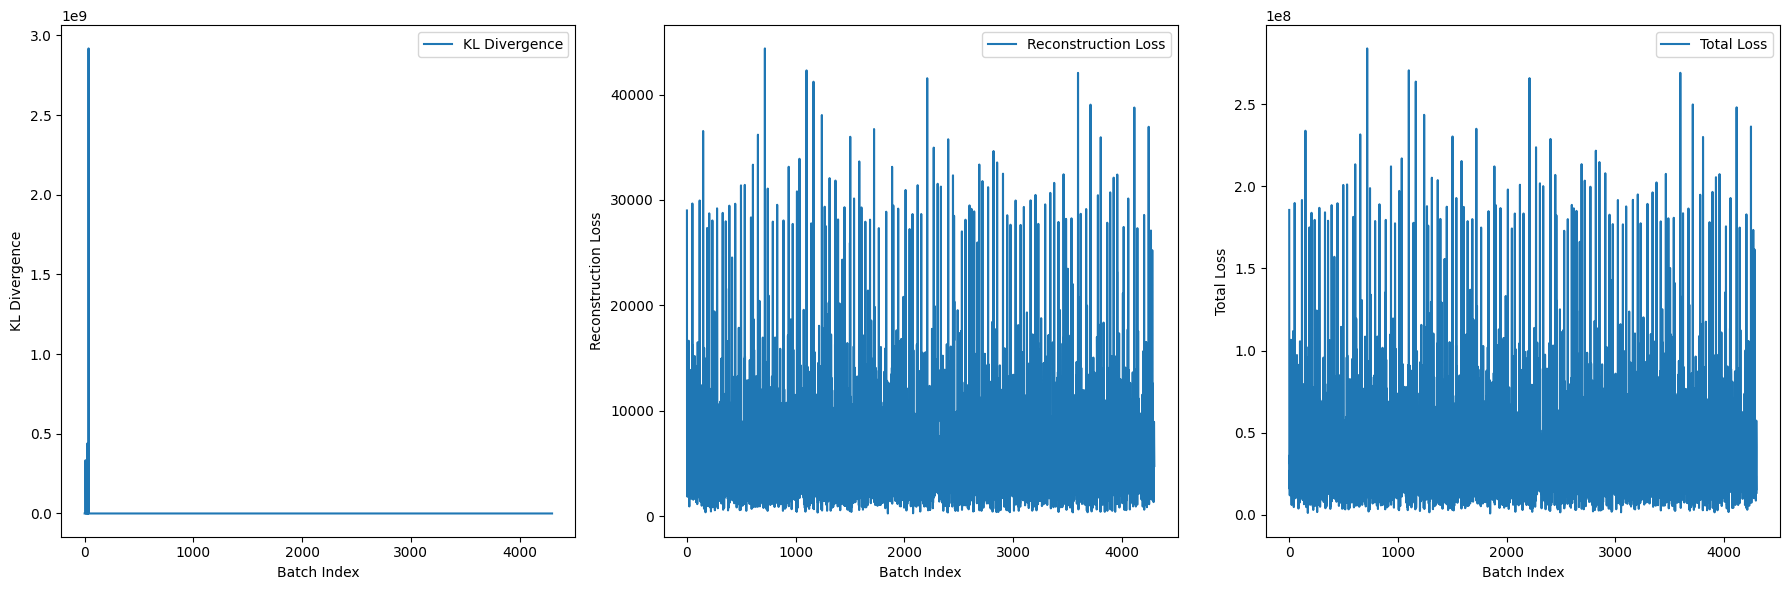

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=200, bias=True)
    (7): Sigmoid()
  )
)

In [ ]:
train(model, train_loader, learning_rate, 100, device, beta_initial, beta_step)


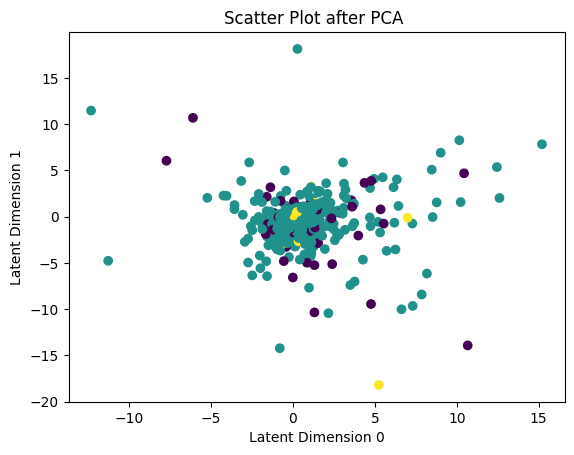

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Thesis/vae_model_pca.pth')
vae_model = VAE(input_dim=input_dim, latent_dim=2)  # Make sure to provide the correct input and latent dimensions
vae_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Thesis/vae_model_pca.pth'))
vae_model.eval()  # Set the model in evaluation mode

vae_model.to(device)

encoded_data = []
with torch.no_grad():
    for x in train_loader:
        x = x.float()
        x = x.to(device)  # Move data to the same device as the model
        _, mu, _, _ = vae_model(x)
        encoded_data.append(mu.cpu().numpy())

# Concatenate the latent representations
all_latents = np.concatenate(encoded_data, axis=0)

# Assuming latent space has two dimensions for simplicity
latent_dim1 = 0
latent_dim2 = 1

# Assuming you have labels stored in label_binary
# Create a scatter plot
plt.scatter(all_latents[:, latent_dim1], all_latents[:, latent_dim2], c=label, cmap='viridis')
plt.title('Scatter Plot after PCA ')
plt.xlabel(f'Latent Dimension {latent_dim1}')
plt.ylabel(f'Latent Dimension {latent_dim2}')
#plt.colorbar()
plt.show()

WE start our analysis with the first model with out a PCA tranformation. We know that microbiome and real medical data are very hard data to be captured very well by a deep learning model and we have limitation from  the number of you dataset.

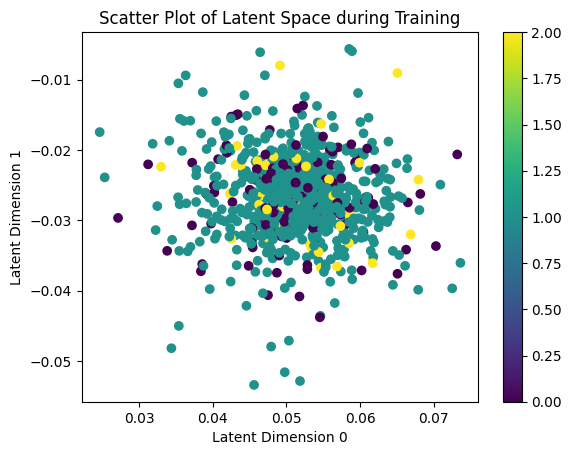

In [ ]:
vae_model = VAE(input_dim=input_dim, latent_dim=6)  # Make sure to provide the correct input and latent dimensions
vae_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Thesis/vae_model_no.pth'))
vae_model.eval()  # Set the model in evaluation mode

vae_model.to(device)

encoded_data = []
with torch.no_grad():
    for x in train_loader:
        x = x.to(device)  # Move data to the same device as the model
        _, mu, _, _ = vae_model(x)
        encoded_data.append(mu.cpu().numpy())

# Concatenate the latent representations
all_latents = np.concatenate(encoded_data, axis=0)

latent_dim1 = 0
latent_dim2 = 1

# Assuming you have labels stored in label_binary
# Create a scatter plot
plt.scatter(all_latents[:, latent_dim1], all_latents[:, latent_dim2], c=label, cmap='viridis')
plt.title('Scatter Plot of Latent Space during Training')
plt.xlabel(f'Latent Dimension {latent_dim1}')
plt.ylabel(f'Latent Dimension {latent_dim2}')
plt.colorbar()
plt.show()

In [ ]:
seed_value = 42
np.random.seed(seed_value)

# Function to find the nearest point in the latent space using Mahalanobis Distance
def find_nearest_point(latent_space, source_class, target_class, distance_metric='euclidean'):
    # Filter data for the specified source and target classes
    source_indices = np.where(label == source_class)[0]
    target_indices = np.where(label == target_class)[0]

    if len(source_indices) == 0 or len(target_indices) == 0:
        return None, None, None  # No points found in one of the classes

    # Select a random point from the source class
    random_source_index = np.random.choice(source_indices)
    random_source_point = latent_space[random_source_index]

    distances = None  # Initialize distances

    if distance_metric == 'euclidean':
        # Calculate Euclidean distances between the random source point and all target points
        distances = np.linalg.norm(latent_space[target_indices] - random_source_point, axis=1)
    elif distance_metric == 'manhattan':
        # Calculate Manhattan distances between the random source point and all target points
        distances = np.sum(np.abs(latent_space[target_indices] - random_source_point), axis=1)
    elif distance_metric == 'chebyshev':
        # Calculate Chebyshev distances between the random source point and all target points
        distances = np.max(np.abs(latent_space[target_indices] - random_source_point), axis=1)
    else:
        raise ValueError("Invalid distance metric. Use 'euclidean', 'manhattan', 'mahalanobis', or 'chebyshev'.")

    # Find the index of the nearest point in the target class
    nearest_target_index = target_indices[np.argmin(distances)]
    nearest_target_point = latent_space[nearest_target_index]

    return random_source_point, nearest_target_point, np.min(distances)

Random point from class 2: [ 0.04948246 -0.02594178 -0.02718361  0.03558382  0.02795946 -0.03728633]
Nearest point in class 0: [ 0.05015226 -0.02569318 -0.02678694  0.03554209  0.02808999 -0.03697322]
Chebyshev distance: 0.00


<ipython-input-43-dbb214ef698a>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10')


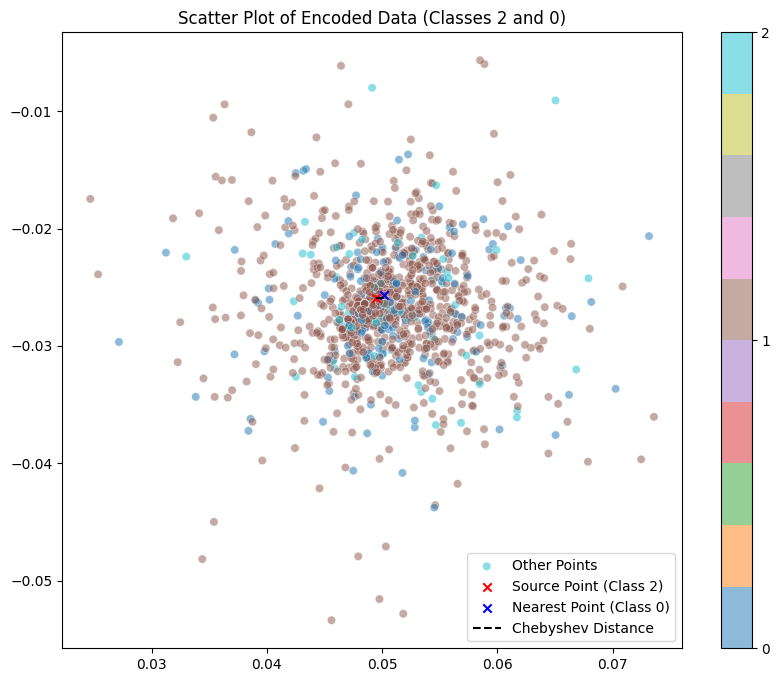

In [ ]:
source_class = 2
target_class = 0
distance_metric = 'chebyshev'  # Change to 'mahalanobis' for Mahalanobis Distance

# Find the nearest point in the latent space
random_source_point, nearest_target_point, distance = find_nearest_point(all_latents, source_class, target_class, distance_metric)

if random_source_point is not None:
    print(f"Random point from class {source_class}: {random_source_point}")
    print(f"Nearest point in class {target_class}: {nearest_target_point}")
    print(f"{distance_metric.capitalize()} distance: {distance:.2f}")
else:
    print("No points found in one of the classes.")

# Visualization code
if random_source_point is not None:
    plt.figure(figsize=(10, 8))

    # Define the color map and create scatter plot
    color_map = plt.cm.get_cmap('tab10')
    scatter = plt.scatter(all_latents[:, 0], all_latents[:, 1], c=label, cmap=color_map, alpha=0.5, edgecolors='w', linewidth=0.5, label='Other Points')

    # Scatter plot for the source and target points
    plt.scatter(random_source_point[0], random_source_point[1], c='red', marker='x', label=f'Source Point (Class {source_class})', alpha=1.0)
    plt.scatter(nearest_target_point[0], nearest_target_point[1], c='blue', marker='x', label=f'Nearest Point (Class {target_class})', alpha=1.0)

    # Draw a line or rectangle connecting the source and target points
    if distance_metric == 'euclidean':
        plt.plot([random_source_point[0], nearest_target_point[0]], [random_source_point[1], nearest_target_point[1]], 'k--', label=f'{distance_metric.capitalize()} Distance')
    elif distance_metric == 'manhattan':
        # Calculate absolute coordinate differences
        dx = abs(random_source_point[0] - nearest_target_point[0])
        dy = abs(random_source_point[1] - nearest_target_point[1])

        # Draw rectangles based on differences
        rect = plt.Rectangle((min(random_source_point[0], nearest_target_point[0]), min(random_source_point[1], nearest_target_point[1])),
                            dx, dy, linewidth=1, edgecolor='k', facecolor='none', label=f'{distance_metric.capitalize()} Distance')
        plt.gca().add_patch(rect)
    elif distance_metric == 'chebyshev':
        # For Chebyshev distance, draw the line along the maximum coordinate difference
        max_difference = np.max(np.abs(nearest_target_point - random_source_point))
        plt.plot([random_source_point[0], nearest_target_point[0], nearest_target_point[0]],
                [random_source_point[1], random_source_point[1], nearest_target_point[1]], 'k--', label=f'{distance_metric.capitalize()} Distance')

    unique_labels = np.unique(label)
    cbar = plt.colorbar(scatter, ticks=np.arange(len(unique_labels)))
    cbar.ax.set_yticklabels(unique_labels)

    # Set plot title and add legend
    plt.title(f"Scatter Plot of Encoded Data (Classes {source_class} and {target_class})")
    plt.legend()

    plt.show()
else:
    print("No points found in one of the classes.")

In [ ]:
num_unique_labels

3

In [ ]:
pd.set_option('display.max_columns', None)
meta.head()

,#SampleID,BarcodeSequence,LinkerPrimerSequence,TARGET_SUBFRAGMENT,ASSIGNED_FROM_GEO,EXPERIMENT_CENTER,TITLE,RUN_PREFIX,AGE,MESALAMINE,BIRTHDATE,HOST_COMMON_NAME,DEPTH,HOST_TAXID,ILLUMINA_TECHNOLOGY,COMMON_NAME,SEX,GASTRIC_INVOLVEMENT,DISEASE_DURATION,BODY_SITE,PERIANAL,ELEVATION,RUN_DATE,TYPE_SAMPLE,COLLECTION_DATE,ALTITUDE,STEROIDS,ENV_BIOME,INFLAMMATIONSTATUS,PLATFORM,ANTIBIOTICS,RACE,STUDY_CENTER,COUNTRY,SMOKING,COLLECTION,HOST_SUBJECT_ID,ANONYMIZED_NAME,TAXON_ID,SAMPLE_CENTER,SAMP_SIZE,DISEASE_EXTENT,AGE_UNIT,STUDY_ID,DISEASESUBTYPE,EXPERIMENT_DESIGN_DESCRIPTION,BIOLOGICS,DIAGNOSIS,BODY_HABITAT,SEQUENCING_METH,B_CAT,IMMUNOSUP,LONGITUDE,ENV_MATTER,TARGET_GENE,DISEASE_STAT,ENV_FEATURE,KEY_SEQ,BIOPSY_LOCATION,BODY_PRODUCT,ILEAL_INVOVLEMENT,REGION,RUN_CENTER,PCR_PRIMERS,LIBRARY_CONSTRUCTION_PROTOCOL,GASTROINTEST_DISORD,LATITUDE,EXTERNAL_ID,Description_duplicate,Description,GASTROINTEST_DISORD_binary
0,SKBTI.1325.1246591,None,GTGCCAGCMGCCGCGGTAA,V4,n,BI,CCFA_RISK,A2G81.1.Solexa-161197,9.083333333,no,None,human,0,9606,MiSeq,human gut metagenome,female,yes,0,UBERON:ileum,no,15.34,None,biopsy,9/2/09,0.0,no,ENVO:urban biome,None,Illumina,no,caucasian,BI,GAZ:United States of America,None,RISK,1939:M1-0741,SKBTI.1325,408170,BI,".1,g",L3,years,1939,IC,study of normal and IBD samples,no,IC,UBERON:gastrointestinal system,sequencing by synthesis,B1,no,-71.06,ENVO:organic material,16S rRNA,None,ENVO:human-associated habitat,None,Terminal ileum,UBERON:mucosa,yes,None,BI,FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,This analysis was done as in Caporaso et al 20...,IC,42.358,SKBTI.1325,M1-0741 biopsy,CCFA_RISK,2
1,121283.1246600,None,GTGCCAGCMGCCGCGGTAA,V4,n,BI,CCFA_RISK,A2NWB.1.Solexa-136332,22.0,None,9/26/89,human,0,9606,MiSeq,human gut metagenome,male,no,0,UBERON:feces,no,15.34,None,stool,8/14/12,0.0,None,ENVO:urban biome,None,Illumina,None,caucasian,BI,GAZ:United States of America,Former,PRISM,1939:8603,121283,408170,BI,".1,g",L1,years,1939,iCD,study of normal and IBD samples,None,CD,UBERON:feces,sequencing by synthesis,B1,None,-71.06,ENVO:feces,16S rRNA,None,ENVO:human-associated habitat,None,stool,UBERON:feces,yes,None,BI,FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,This analysis was done as in Caporaso et al 20...,CD,42.358,121283,8603 stool,CCFA_RISK,1
2,SKBTI.0870.1246169,None,GTGCCAGCMGCCGCGGTAA,V4,n,BI,CCFA_RISK,A29H3.1.Solexa-146974,15.41666667,no,None,human,0,9606,MiSeq,human gut metagenome,male,yes,0,UBERON:rectum,no,15.34,None,biopsy,12/21/10,0.0,no,ENVO:urban biome,inflamed,Illumina,no,african,BI,GAZ:United States of America,None,RISK,1939:M1-0606,SKBTI.0870,408170,BI,".1,g",L2,years,1939,cCD,study of normal and IBD samples,no,CD,UBERON:gastrointestinal system,sequencing by synthesis,B1,no,-71.06,ENVO:organic material,16S rRNA,inflamed,ENVO:human-associated habitat,None,Rectum,UBERON:mucosa,no,None,BI,FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,This analysis was done as in Caporaso et al 20...,CD,42.358,SKBTI.0870,M1-0606 biopsy,CCFA_RISK,1
3,SKBTI.1178.1246304,None,GTGCCAGCMGCCGCGGTAA,V4,n,BI,CCFA_RISK,A4848.1.Solexa-162352,12.16666667,no,None,human,0,9606,MiSeq,human gut metagenome,female,no,0,UBERON:rectum,no,15.34,None,biopsy,1/28/11,0.0,no,ENVO:urban biome,None,Illumina,no,None,BI,GAZ:United States of America,None,RISK,1939:M1-0453,SKBTI.1178,408170,BI,".1,g",None,years,1939,no,study of normal and IBD samples,no,no,UBERON:gastrointestinal system,sequencing by synthesis,B1,no,-71.06,ENVO:organic material,16S rRNA,None,ENVO:human-associated habitat,None,Rectum,UBERON:mucosa,None,None,BI,FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,This analysis was done as in Caporaso et al 20...,no,42.358,SKBTI.1178,M1-0453 biopsy,CCFA_RISK,1
4,MGH101468.1246593,None,GTGCCAGCMGCCGCGGTAA,V4,n,BI,CCFA_RISK,A2246.1.Solexa-125757,49.0,yes,4/20/58,human,0,9606,MiSeq,human gut metagenome,male,no,34,UBERON:colon,no,15.34,None,biopsy,11/6/07,0.0,no,ENVO:urban biome,non-inflamed,Illumina,no,None,BI,GAZ:United States of Americ

In [ ]:
df = meta[['AGE', 'SEX', 'ANTIBIOTICS', 'SMOKING']] #'GASTROINTEST_DISORD'

# Display the range of values for each column
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        column_range = (df[column].min(), df[column].max())
    else:
        column_range = df[column].unique()

    print(f"Column: {column}, Range: {column_range}")

Column: AGE, Range: ['9.083333333' '22.0' '15.41666667' '12.16666667' '49.0' '14.33333333'
 '11.58333333' '11.91666667' '30.0' '13.58333333' '16.5' '5.333333333'
 '8.833333333' '32.0' '40.0' '15.33333333' '10.58333333' '16.08333333'
 '35.0' '41.0' '15.5' '60.0' '39.0' '13.91666667' '7.833333333'
 '15.16666667' '13.25' '10.83333333' '10.66666667' '4.5' '8.583333333'
 '15.83333333' '20.0' '12.75' '14.58333333' '15.0' '8.0' '13.08333333'
 '10.91666667' '14.41666667' '4.166666667' '13.66666667' '7.25'
 '14.08333333' '11.83333333' '16.83333333' '11.5' '13.75' '16.91666667'
 '56.0' '12.83333333' '14.5' '12.5' '44.0' '15.58333333' '54.0' '21.0'
 '8.75' '9.25' '9.583333333' '77.0' '12.41666667' '47.0' '5.916666667'
 '24.0' '8.25' '19.0' '7.583333333' '7.333333333' '12.33333333' '29.0'
 '13.41666667' '37.0' '16.75' '16.25' '4.333333333' '12.91666667'
 '15.91666667' '14.16666667' '14.75' '9.416666667' '10.41666667'
 '10.16666667' '65.0' '6.166666667' '9.0' '51.0' '33.0' '68.0' '62.0'
 '13.0' '10

In [ ]:
# Transformation for SMOKING
df['SMOKING'] = df['SMOKING'].apply(lambda x: 1 if x in ['Current', '2'] else 0)

# Transformation for ANTIBIOTICS
df['ANTIBIOTICS'] = df['ANTIBIOTICS'].apply(lambda x: 1 if x == 'yes' else 0)

# Transformation for SEX
df['SEX'] = df['SEX'].apply(lambda x: 1 if x == 'male' else 0)

# Convert AGE column to numeric
df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce')  # 'coerce' will handle non-numeric values by converting them to NaN
#df['GASTROINTEST_DISORD'] = df['GASTROINTEST_DISORD'].apply(lambda x:1 if x=="no" else 0)

# Discretize AGE based on custom logic
def discretize_age(age):
    if age <= 18:
        return '0-18'
    elif age <= 30:
        return '19-30'
    elif age <= 50:
        return '31-50'
    else:
        return '51+'

df['AGE'] = df['AGE'].apply(discretize_age)

print(df)

        AGE  SEX  ANTIBIOTICS  SMOKING
0      0-18    0            0        0
1     19-30    1            0        0
2      0-18    1            0        0
3      0-18    0            0        0
4     31-50    1            0        0
...     ...  ...          ...      ...
1353   0-18    1            0        0
1354   0-18    1            0        0
1355   0-18    0            1        0
1356   0-18    1            0        0
1357   0-18    0            0        0

[1358 rows x 4 columns]


<ipython-input-46-b72b3ad163de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMOKING'] = df['SMOKING'].apply(lambda x: 1 if x in ['Current', '2'] else 0)
<ipython-input-46-b72b3ad163de>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ANTIBIOTICS'] = df['ANTIBIOTICS'].apply(lambda x: 1 if x == 'yes' else 0)
<ipython-input-46-b72b3ad163de>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [ ]:
label.shape

(1358,)

In [ ]:
for column in df.columns:
    value_counts = df[column].value_counts()
    print(f"Column: {column}, Value Counts:\n{value_counts}\n")

Column: AGE, Value Counts:
0-18     991
31-50    139
19-30    132
51+       96
Name: AGE, dtype: int64

Column: SEX, Value Counts:
1    725
0    633
Name: SEX, dtype: int64

Column: ANTIBIOTICS, Value Counts:
0    1294
1      64
Name: ANTIBIOTICS, dtype: int64

Column: SMOKING, Value Counts:
0    1302
1      56
Name: SMOKING, dtype: int64



In [ ]:
def find_nearest_point_with_constraints(latent_space, label, df, source_class, target_class, distance_metric='euclidean'):
    # Filter data for the specified source and target classes
    source_indices = np.where(label == source_class)[0]
    target_indices = np.where(label == target_class)[0]

    if len(source_indices) == 0 or len(target_indices) == 0:
        return None, None, None  # No points found in one of the classes

    # Select a random point from the source class
    random_source_index = np.random.choice(source_indices)
    random_source_point = latent_space[random_source_index]

    # Retrieve metadata for the selected source point
    source_metadata = df.iloc[random_source_index]

    # Filter target indices to match the source point metadata
    matching_target_indices = []
    for idx in target_indices:
        target_metadata = df.iloc[idx]
        if all(source_metadata[['AGE', 'SEX', 'ANTIBIOTICS', 'SMOKING']] == target_metadata[['AGE', 'SEX', 'ANTIBIOTICS', 'SMOKING']]):
            matching_target_indices.append(idx)

    # If no matching target points are found, return None
    if not matching_target_indices:
        return None, None, None

    # Convert to numpy array for distance calculations
    matching_target_indices = np.array(matching_target_indices)

    distances = None  # Initialize distances

    # Calculate distances based on the selected metric
    if distance_metric == 'euclidean':
        distances = np.linalg.norm(latent_space[matching_target_indices] - random_source_point, axis=1)
    elif distance_metric == 'manhattan':
        distances = np.sum(np.abs(latent_space[matching_target_indices] - random_source_point), axis=1)
    elif distance_metric == 'chebyshev':
        distances = np.max(np.abs(latent_space[matching_target_indices] - random_source_point), axis=1)
    else:
        raise ValueError("Invalid distance metric. Use 'euclidean', 'manhattan', or 'chebyshev'.")

    # Find the index of the nearest point in the target class with matching metadata
    nearest_target_index = matching_target_indices[np.argmin(distances)]
    nearest_target_point = latent_space[nearest_target_index]

    source_index = random_source_index  # This should be the index of your random source point
    target_index = nearest_target_index  # This should be the index of your nearest target point

    # Print metadata for the source point
    print("Source Point Metadata:")
    print(df.iloc[source_index])

    # Print metadata for the nearest target point
    print("Nearest Target Point Metadata:")
    print(df.iloc[target_index])

    return random_source_point, nearest_target_point, np.min(distances), source_index, target_index


Source Point Metadata:
AGE            19-30
SEX                1
ANTIBIOTICS        0
SMOKING            1
Name: 106, dtype: object
Nearest Target Point Metadata:
AGE            19-30
SEX                1
ANTIBIOTICS        0
SMOKING            1
Name: 1068, dtype: object
Random point from class 0: [ 0.04898468 -0.0267708  -0.02897138  0.03526648  0.02884378 -0.0398272 ]
Nearest point in class 1 with matching AGE, SEX, ANTIBIOTICS, SMOKING: [ 0.05218661 -0.03029137 -0.02709556  0.02920945  0.03043326 -0.03691578]
Chebyshev distance: 0.01


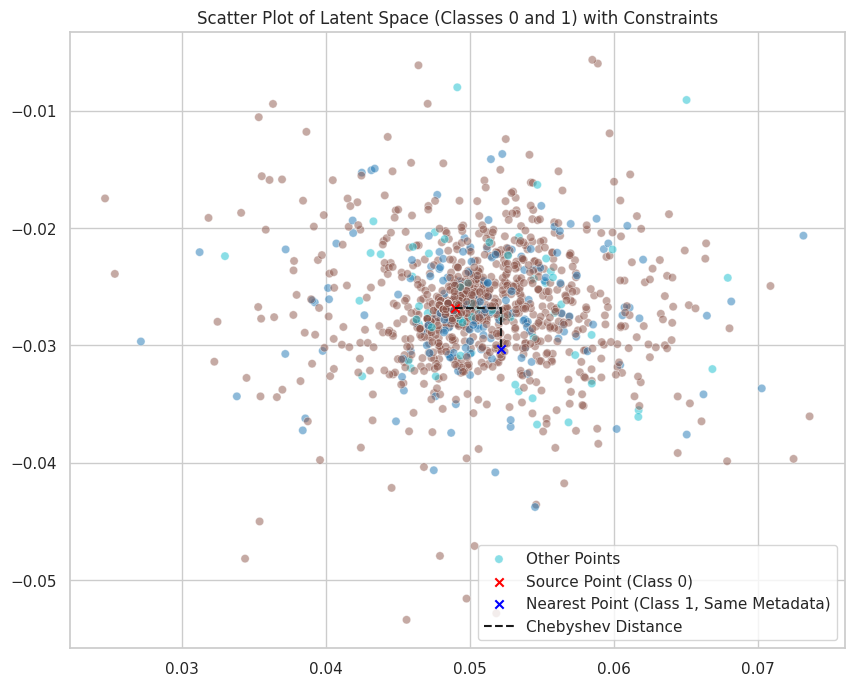

In [ ]:
source_class = 0
target_class = 1
distance_metric = 'chebyshev'  # Change to 'mahalanobis' for Mahalanobis Distance

# Find the nearest point in the latent space with constraints
random_source_point, nearest_target_point, distance , source_index, target_index = find_nearest_point_with_constraints(all_latents, label, df, source_class, target_class, distance_metric)

if random_source_point is not None:
    print(f"Random point from class {source_class}: {random_source_point}")
    print(f"Nearest point in class {target_class} with matching AGE, SEX, ANTIBIOTICS, SMOKING: {nearest_target_point}")
    print(f"{distance_metric.capitalize()} distance: {distance:.2f}")
else:
    print("No points found in one of the classes.")

# Visualization code
if random_source_point is not None:
    plt.figure(figsize=(10, 8))

    # Scatter plot of all data points with alpha for transparency and a color gradient based on the labels
    scatter = plt.scatter(all_latents[:, 0], all_latents[:, 1], c=label, cmap='tab10', alpha=0.5, edgecolors='w', linewidth=0.5, label='Other Points')

    # Scatter plot for the source point in red with no alpha
    plt.scatter(random_source_point[0], random_source_point[1], c='red', marker='x', label=f'Source Point (Class {source_class})', alpha=1.0)

    # Scatter plot for the nearest target point in blue with no alpha
    plt.scatter(nearest_target_point[0], nearest_target_point[1], c='blue', marker='x', label=f'Nearest Point (Class {target_class}, Same Metadata)', alpha=1.0)

    # Draw a line or rectangle connecting the source and target points
    if distance_metric == 'euclidean':
        plt.plot([random_source_point[0], nearest_target_point[0]], [random_source_point[1], nearest_target_point[1]], 'k--', label=f'{distance_metric.capitalize()} Distance')
    elif distance_metric == 'manhattan':
        dx = abs(random_source_point[0] - nearest_target_point[0])
        dy = abs(random_source_point[1] - nearest_target_point[1])
        rect = plt.Rectangle((min(random_source_point[0], nearest_target_point[0]), min(random_source_point[1], nearest_target_point[1])),
                            dx, dy, linewidth=1, edgecolor='k', facecolor='none', label=f'{distance_metric.capitalize()} Distance')
        plt.gca().add_patch(rect)
    elif distance_metric == 'chebyshev':
        max_difference = np.max(np.abs(nearest_target_point - random_source_point))
        plt.plot([random_source_point[0], nearest_target_point[0], nearest_target_point[0]],
                [random_source_point[1], random_source_point[1], nearest_target_point[1]], 'k--', label=f'{distance_metric.capitalize()} Distance')

    #plt.colorbar(scatter)
    plt.title(f"Scatter Plot of Latent Space (Classes {source_class} and {target_class}) with Constraints")
    plt.legend()
    plt.show()
else:
    print("No points found in one of the classes.")

In [ ]:
device = next(vae_model.parameters()).device
print("Model is on:", device)

tensor_source_point = torch.tensor(random_source_point, dtype=torch.float32).to(device)
tensor_target_point = torch.tensor(nearest_target_point, dtype=torch.float32).to(device)

decoded_source = vae_model.decoder(tensor_source_point).detach()
decoded_target = vae_model.decoder(tensor_target_point).detach()

restored_source = np.expm1(decoded_source.cpu().numpy())
restored_target = np.expm1(decoded_target.cpu().numpy())


Model is on: cuda:0


In [ ]:
original_source_data = taxa_data.iloc[source_index]
original_target_data = taxa_data.iloc[target_index]

In [ ]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests


# Assuming original_source_data and original_target_data are arrays or pandas series
p_values = np.array([ttest_ind([source_abundance], [target_abundance])[1]
                     for source_abundance, target_abundance in zip(original_source_data, original_target_data)])
corrected_p_values = multipletests(p_values, method='fdr_bh')[1]
alpha = 0.05
significant = corrected_p_values < alpha
heatmap_data = np.vstack([original_source_data, original_target_data, significant.astype(int)])


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:7030: RuntimeWarning: invalid value encountered in double_scalars
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


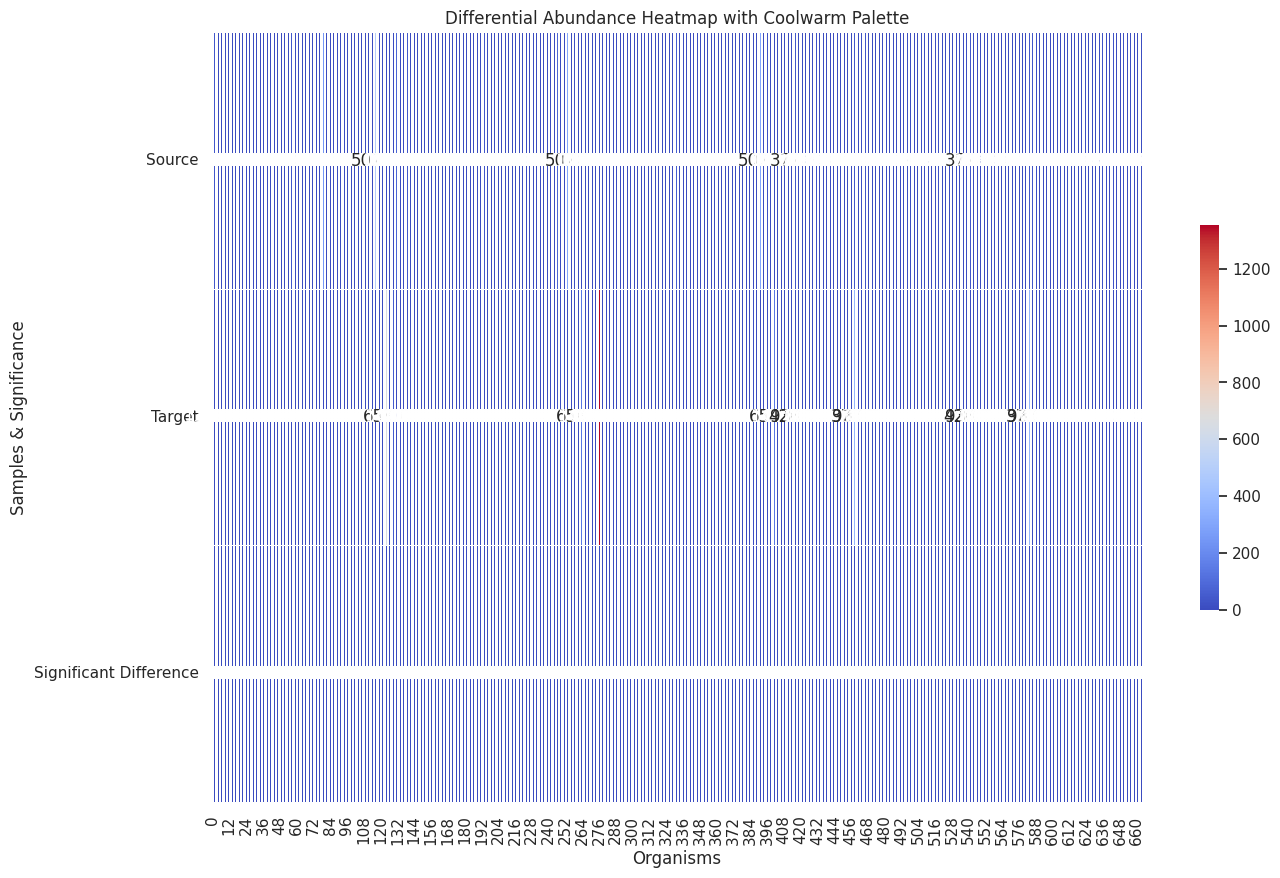

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming heatmap_data is already prepared as shown previously
plt.figure(figsize=(15, 10))  # Adjust size for better visibility
sns.set(style="whitegrid")    # Set a background style

ax = sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".1f", linewidths=.5, cbar_kws={"shrink": .5})
ax.set_yticklabels(['Source', 'Target', 'Significant Difference'], rotation=0)
plt.title("Differential Abundance Heatmap with Coolwarm Palette")
plt.xlabel("Organisms")
plt.ylabel("Samples & Significance")
plt.show()


In [ ]:
# Calculate absolute difference
difference = np.abs(original_source_data - original_target_data)
# Get indices of top 5 differences
top_5_indices = np.argsort(difference)[-5:]

# Retrieve organism names if available (assuming taxa_data has column names as organism names)
top_5_organisms = taxa_data.columns[top_5_indices]

# Retrieve abundance values for these organisms
top_5_source_values = original_source_data[top_5_indices]
top_5_target_values = original_target_data[top_5_indices]
top_5_differences = difference[top_5_indices]
import pandas as pd

summary_table = pd.DataFrame({
    'Organism': top_5_organisms,
    'Source Abundance': top_5_source_values,
    'Target Abundance': top_5_target_values,
    'Difference': top_5_differences
})
summary_table

,Organism,Source Abundance,Target Abundance,Difference
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides vulgatus;t__Bacteroides vulgatus ATCC 8482.4,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,119.995708,933.0,813.004292
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides vulgatus;t__Bacteroides vulgatus ATCC 8482.3,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,119.995708,933.0,813.004292
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides.2,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,1.000000,1356.0,1355.000000
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides.1,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,1.000000,1356.0,1355.000000
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,1.000000,1356.0,1355.000000


In [ ]:

neighbors = NearestNeighbors(n_neighbors=6)  # 6 because the first neighbor is the point itself
neighbors.fit(all_latents)
distances, indices = neighbors.kneighbors(all_latents)

G = nx.Graph()

# Add nodes
for i in range(len(all_latents)):
    G.add_node(i)

# Add edges
for i in range(len(all_latents)):
    for j in indices[i][1:]:  # Skip the first neighbor (the point itself)
        G.add_edge(i, j)

label_dict = {i: label[i] for i in range(len(label))}


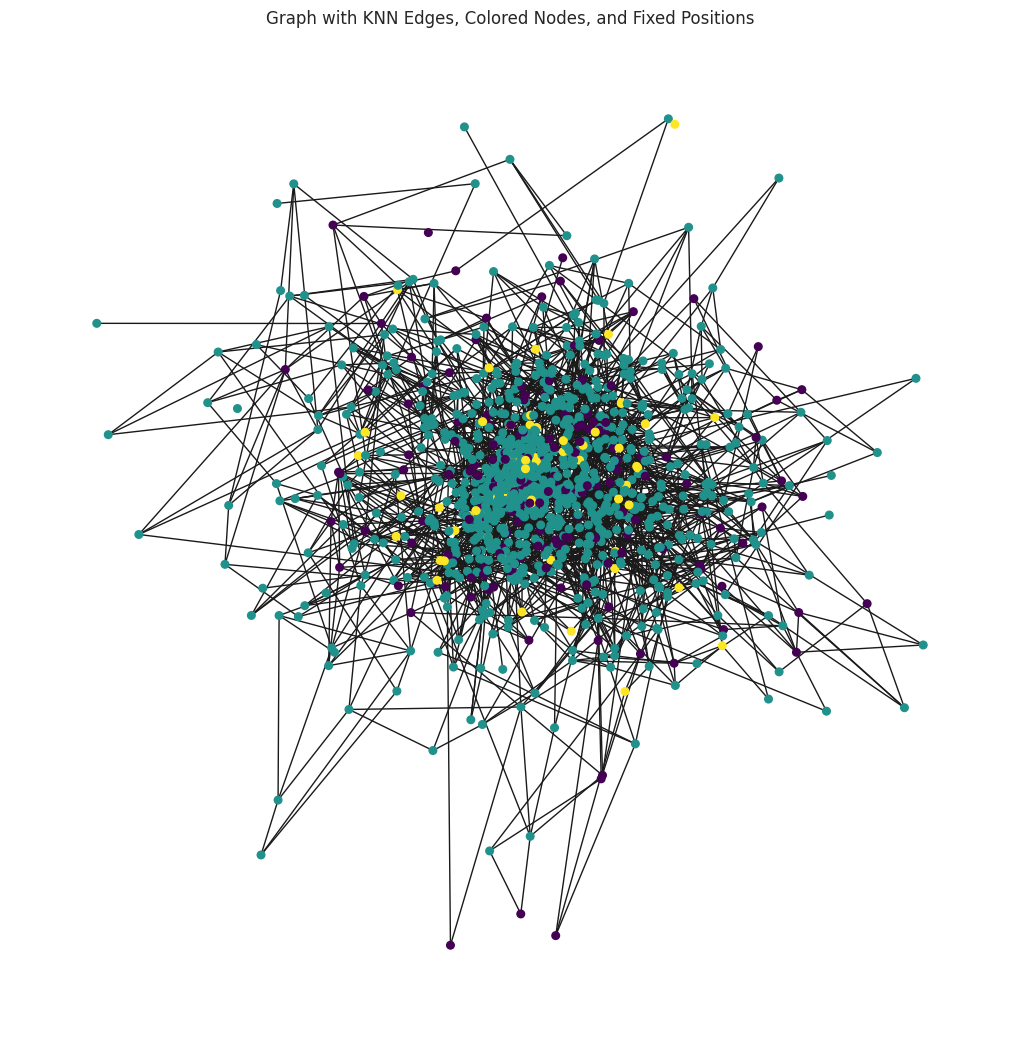

In [ ]:
from sklearn.neighbors import kneighbors_graph

# Step 1: Create the KNN graph
k_neighbors = 5 # Number of neighbors
knn_graph = kneighbors_graph(all_latents, n_neighbors=k_neighbors, mode='connectivity', include_self=False)

# Get the adjacency matrix from the sparse matrix
adjacency_matrix = knn_graph.todense()

# Create a graph and add edges from the adjacency matrix
graph = nx.Graph()
graph.add_nodes_from(range(len(all_latents)))

# Add edges based on node positions in the original graph
for i in range(len(all_latents)):
    for j in range(i + 1, len(all_latents)):
        distance = np.linalg.norm(all_latents[i] - all_latents[j])
        if adjacency_matrix[i, j] > 0 and distance > 0:
            graph.add_edge(i, j, weight=distance)

# Set node positions based on encoded_data , only 2 dimensions
pos = {i: (all_latents[i][0], all_latents[i][1]) for i in range(len(all_latents))}

# Get colors based on filtered labels
unique_labels = list(set(label))
label_colors = {unique_labels[i]: i for i in range(len(unique_labels))}

node_colors = [label_colors[label] for label in label]

# Visualize the graph with colored nodes and fixed positions
plt.figure(figsize=(10, 10))
cmap = plt.get_cmap('viridis', len(unique_labels))
nx.draw(graph, pos, node_color=node_colors, cmap=cmap, node_size=30)
plt.title("Graph with KNN Edges, Colored Nodes, and Fixed Positions")
plt.show()


In [ ]:


for i in range(len(all_latents)):
    for j in range(i + 1, len(all_latents)):
        # Only connect nodes with the same AGE, ANTIBIOTICS, and SMOKING
        if (df.iloc[i]['AGE'] == df.iloc[j]['AGE'] and
            df.iloc[i]['ANTIBIOTICS'] == df.iloc[j]['ANTIBIOTICS'] and
            df.iloc[i]['SMOKING'] == df.iloc[j]['SMOKING']):

            distance = np.linalg.norm(all_latents[i] - all_latents[j])
            if adjacency_matrix[i, j] > 0 and distance > 0:
                weight = distance if df.iloc[i]['AGE'] == df.iloc[j]['AGE'] else distance * 10  # Adjust multiplier as needed
                graph.add_edge(i, j, weight=weight)



In [ ]:
import random

class_1_nodes = [i for i, label in enumerate(label) if label == 1]
start_node = random.choice(class_1_nodes)  # or select based on specific criteria


In [ ]:
class_0_nodes = [i for i, label in enumerate(label) if label == 0]

# Filter class 0 nodes to match the metadata of the start node
matching_class_0_nodes = [node for node in class_0_nodes if all(df.iloc[start_node][['AGE', 'SEX', 'ANTIBIOTICS', 'SMOKING']] == df.iloc[node][['AGE', 'SEX', 'ANTIBIOTICS', 'SMOKING']])]

shortest_path = None
min_path_length = np.inf

for target_node in matching_class_0_nodes:
    try:
        path_length = nx.shortest_path_length(graph, start_node, target_node, weight='weight')
        if path_length < min_path_length:
            min_path_length = path_length
            shortest_path = nx.shortest_path(graph, start_node, target_node, weight='weight')
    except nx.NetworkXNoPath:
        continue

In [ ]:
cmap = plt.get_cmap('viridis', len(set(label)))
node_colors = [label[i] for i in range(len(label))]

# Use the first two dimensions from all_latents for node positions
pos = {i: (all_latents[i][0], all_latents[i][1]) for i in range(len(all_latents))}

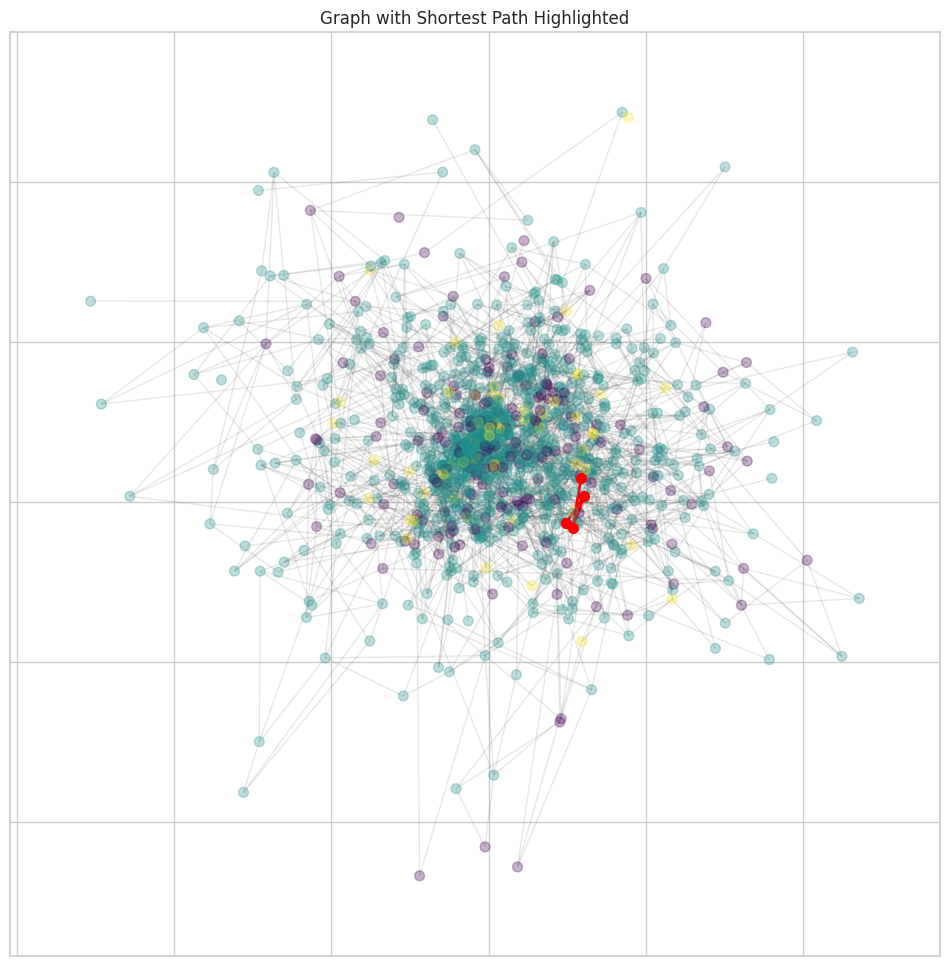

Shortest Path: [407, 158, 360, 514]


In [ ]:
plt.figure(figsize=(12, 12))

# Draw all nodes with reduced alpha
nx.draw_networkx_nodes(graph, pos, node_color=node_colors, cmap=cmap, alpha=0.3, node_size=50)

# Draw all edges with reduced alpha
nx.draw_networkx_edges(graph, pos, alpha=0.1)

# Highlight the shortest path
if shortest_path:
    path_edges = list(zip(shortest_path, shortest_path[1:]))
    nx.draw_networkx_nodes(graph, pos, nodelist=shortest_path, node_color='red', alpha=1, node_size=50)
    nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='red', width=2)

plt.title("Graph with Shortest Path Highlighted")
plt.show()

# Print the shortest path
if shortest_path:
    print("Shortest Path:", shortest_path)
else:
    print("No path found.")


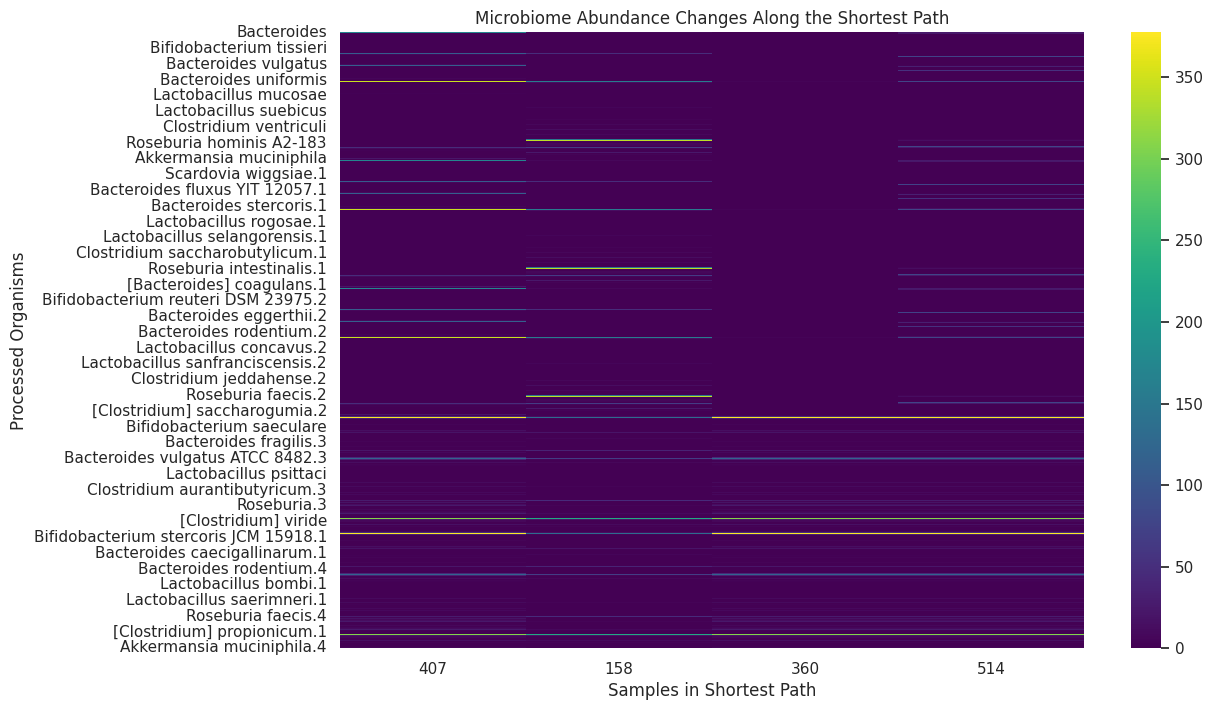

In [ ]:
processed_columns = ['_'.join(col.split('_')[-1:]) for col in taxa_data.columns]
taxa_data.columns = processed_columns
path_taxa_data = taxa_data.iloc[shortest_path]
plt.figure(figsize=(12, 8))  # Adjust the size for better visibility
sns.heatmap(path_taxa_data.T, cmap="viridis")
plt.title("Microbiome Abundance Changes Along the Shortest Path")
plt.xlabel("Samples in Shortest Path")
plt.ylabel("Processed Organisms")
plt.show()

In [ ]:
start_node_data = taxa_data.iloc[shortest_path[0]]
end_node_data = taxa_data.iloc[shortest_path[-1]]
difference = end_node_data - start_node_data

organisms = processed_columns
difference_df = pd.DataFrame({
    'Organism': organisms,
    'Difference': difference.values
})

# Sort by absolute difference in descending order
difference_df = difference.reindex(difference.abs().sort_values(ascending=False).index)
difference_df

Bacteroides vulgatus ATCC 8482       -272.0
Bacteroides vulgatus ATCC 8482.1     -272.0
Bacteroides vulgatus ATCC 8482.2     -272.0
Bacteroides                          -147.0
Bacteroides.2                        -147.0
                                      ...  
Clostridium ventriculi.1                0.0
Clostridium septicum.1                  0.0
Roseburia.1                             0.0
Clostridium lentocellum DSM 5427.1      0.0
Akkermansia muciniphila.4               0.0
Length: 664, dtype: float64

## Bacteroides vulgatus and Inflammatory Bowel Disease (IBD)

### Overview
*Bacteroides vulgatus* is a species of Gram-negative, anaerobic bacteria commonly found in the human gut. It plays a significant role in the breakdown of proteins and carbohydrates.

### Role in the Microbiome
- *Bacteroides vulgatus* is involved in processing complex molecules in the gut, contributing to the host's intestinal health.
- It's known for its ability to ferment a wide range of molecules and adapt to changes in the gut environment.

### Association with IBD
- Studies suggest a complex role of *Bacteroides vulgatus* in IBD. Some strains might have a protective role, while others could contribute to inflammation associated with IBD.
- For example, *Bacteroides vulgatus ATCC 8482* and its variants (e.g., ATCC 8482.1, ATCC 8482.2) have been studied for their effects on IBD.
- A study published on PubMed noted that *Bacteroides vulgatus* was found in lower abundance in patients with IBD-D (IBD with depression) compared to those without depression. Administration of *Bacteroides vulgatus* or its key metabolite, 4-HPAA, showed amelioration of intestinal inflammation and relief of depressive symptoms, suggesting a therapeutic potential for treating IBD, particularly IBD with depression [[PubMed Source](https://pubmed.ncbi.nlm.nih.gov/33500735/)].

### Strain-Specific Effects
- The specific role and effects of *Bacteroides vulgatus* in IBD can vary depending on the strain and the individual's gut microbiome composition.

### Conclusion
The relationship between *Bacteroides vulgatus* and diseases like IBD is an active area of research. Understanding the specific roles of different strains could lead to targeted therapeutic approaches for gut health.
